In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series


from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split, calculate_loss
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast, get_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [ ]:
for district in predictions_dict.keys():
    district_dict = predictions_dict[district]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-', color='C0', label='E / Hosp (M1)')
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-.', color='C0', label='I / Hosp (M1)')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
    plt.grid()
    plt.show()

## Load Covid19india Data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

#districts_to_show = [('Maharashtra', 'Pune')]
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [6]:
#for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
#                                                                     data_from_tracker=True, initialisation='intermediate',
#                                                                     which_compartments=['hospitalised', 'total_infected'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
#                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
#                                                                     which_compartments=['hospitalised', 'total_infected'])

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
32 2020-05-15  Maharashtra   Mumbai         17607.0       12464.4     4482.2   
33 2020-05-16  Maharashtra   Mumbai         18721.2       13201.4     4827.2   
34 2020-05-17  Maharashtra   Mumbai         19918.0       13986.0     5203.6   
35 2020-05-18  Maharashtra   Mumbai         21202.6       14853.8     5583.2   
36 2020-05-19  Maharashtra   Mumbai         22586.8       15811.8     5972.2   

    deceased  
32     660.4  
33     692.6  
34     728.4  
35     765.6  
36     802.8  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-20  Maharashtra   Mumbai         24007.0       16783.4     6385.8   
1 2020-05-21  Maharashtra   Mumbai         25503.4       17849.4     6777.8   
2 2020-05-22  Maharashtra   Mumbai         27062.6       18979.4     7169.4   
3 2020-05-23 

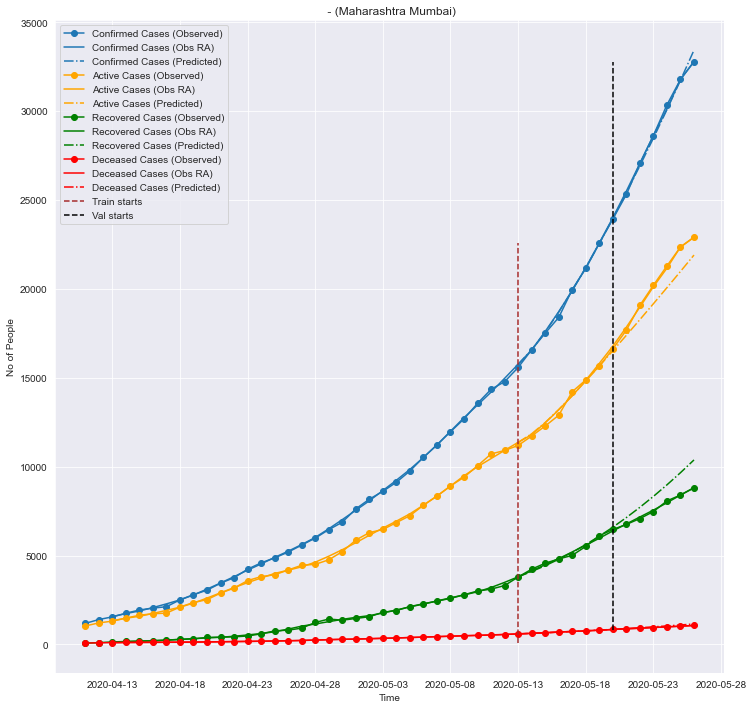

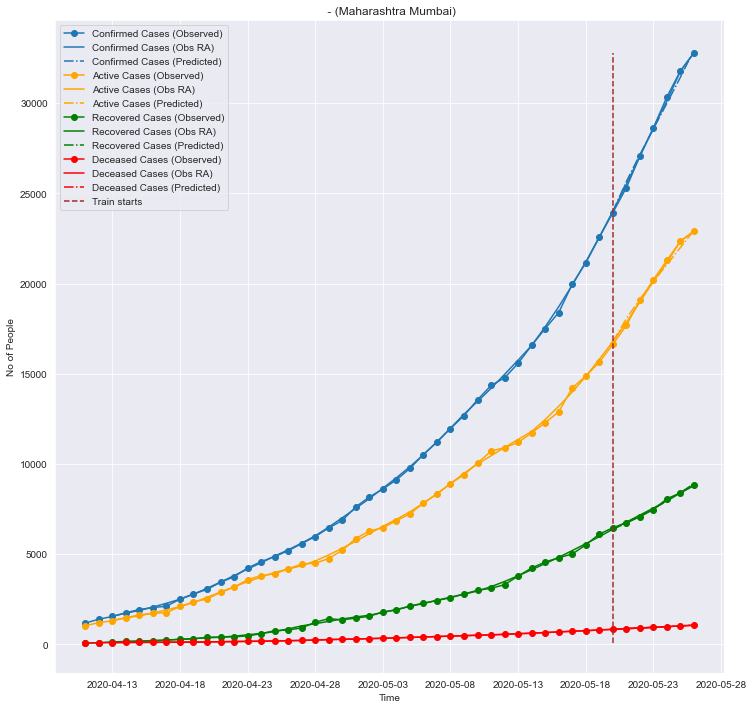

In [7]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=False, 
                                                                     #filename='../../data/data/official-pune-25-05-20.csv', 
                                                                     filename='../../data/data/official-mumbai-27-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, 
                                                                     val_period=0, 
                                                                     train_on_val=True, 
                                                                     data_from_tracker=False, 
                                                                     #filename='../../data/data/official-pune-25-05-20.csv', 
                                                                     filename='../../data/data/official-mumbai-27-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

## Create Master Loss Dataframe

### M1 Loss

In [8]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Mumbai')])

In [9]:
predictions_dict[('Maharashtra','Mumbai')]['m1']

{'data_from_tracker': False,
 'best_params': {'E_hosp_ratio': 0.7456929501308129,
  'I_hosp_ratio': 0.25997607961859714,
  'P_fatal': 0.07195633167141258,
  'P_severe': 0.7611252505478099,
  'T_inc': 4.370904901113043,
  'T_inf': 3.534360653021773,
  'T_recov_severe': 36.35271856808732,
  'lockdown_R0': 1.1991651691765346},
 'default_params': {'N': 10000000.0,
  'lockdown_day': -49,
  'lockdown_removal_day': 18,
  'T_hosp': 0.001,
  'starting_date': Timestamp('2020-05-13 00:00:00'),
  'observed_values': date              2020-05-13 00:00:00
  state                     Maharashtra
  district                       Mumbai
  total_infected                15761.6
  hospitalised                  11367.2
  recovered                      3803.2
  deceased                        591.2
  Name: 30, dtype: object},
 'variable_param_ranges': {'lockdown_R0': <hyperopt.pyll.base.Apply at 0x1353dab00>,
  'T_inc': <hyperopt.pyll.base.Apply at 0x1353dab38>,
  'T_inf': <hyperopt.pyll.base.Apply at 0x1353

In [10]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         1.24           0.52     0.67      1.81   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai          4.2           0.65     3.94      9.14

### M2 Loss

In [11]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[('Maharashtra','Mumbai')]['m2']

{'data_from_tracker': False,
 'best_params': {'E_hosp_ratio': 0.18523560988851562,
  'I_hosp_ratio': 0.44205736669104506,
  'P_fatal': 0.05723302766843777,
  'P_severe': 0.8354104256442497,
  'T_inc': 4.93522114830215,
  'T_inf': 3.725748455082571,
  'T_recov_severe': 49.41121292562031,
  'lockdown_R0': 1.4888986067875347},
 'default_params': {'N': 10000000.0,
  'lockdown_day': -56,
  'lockdown_removal_day': 11,
  'T_hosp': 0.001,
  'starting_date': Timestamp('2020-05-20 00:00:00'),
  'observed_values': date              2020-05-20 00:00:00
  state                     Maharashtra
  district                       Mumbai
  total_infected                  24007
  hospitalised                  16783.4
  recovered                      6385.8
  deceased                        837.8
  Name: 37, dtype: object},
 'variable_param_ranges': {'lockdown_R0': <hyperopt.pyll.base.Apply at 0x13a1d4898>,
  'T_inc': <hyperopt.pyll.base.Apply at 0x13a1d46d8>,
  'T_inf': <hyperopt.pyll.base.Apply at 0x13a1

In [12]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         0.96            0.7     0.41      0.75

## Plot Forecasts

getting forecasts ..


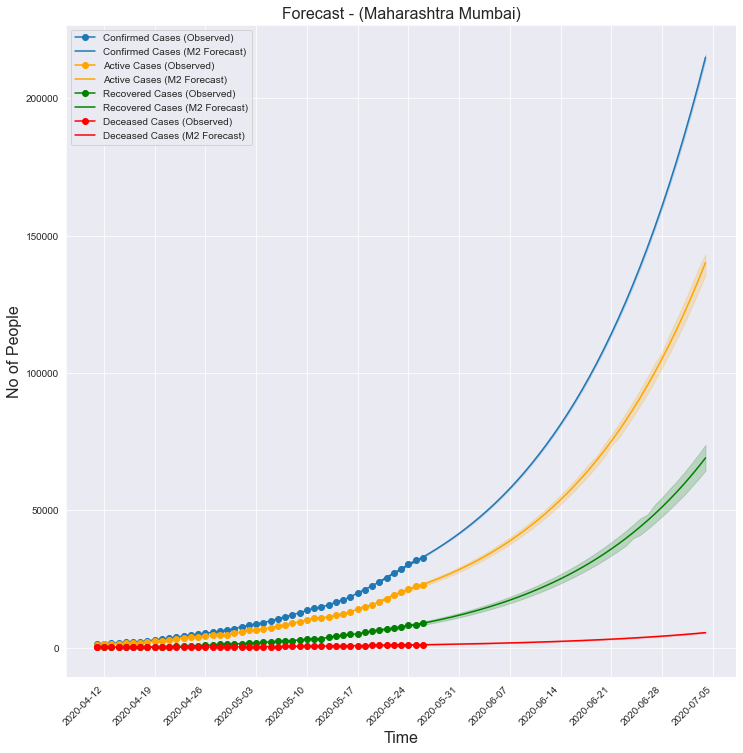

In [13]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [14]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [15]:
write_csv(df_output, '../../output-mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [76]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
#losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
losses_array[least_losses_indices][:10]

array([1.58692877, 1.94039065, 2.5161734 , 2.52963674, 2.55826057,
       2.60047324, 2.60101549, 2.76859406, 2.78626231, 2.86550621])

In [52]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [53]:
least_losses_indices[:10]

array([1357, 1375, 1354, 1459,  890, 1353, 1317, 1298, 1487, 1138])

In [54]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 0.7456929501308129, 'I_hosp_ratio': 0.25997607961859714, 'P_fatal': 0.07195633167141258, 'P_severe': 0.7611252505478099, 'T_inc': 4.370904901113043, 'T_inf': 3.534360653021773, 'T_recov_severe': 36.35271856808732, 'lockdown_R0': 1.1991651691765346},
       {'E_hosp_ratio': 0.8477480713472537, 'I_hosp_ratio': 0.2541803713377981, 'P_fatal': 0.06968647455320973, 'P_severe': 0.7439199361769097, 'T_inc': 4.590177721184146, 'T_inf': 3.5058320623954002, 'T_recov_severe': 35.50614643751729, 'lockdown_R0': 1.1320360522345565},
       {'E_hosp_ratio': 0.7491177825458458, 'I_hosp_ratio': 0.25203999525779464, 'P_fatal': 0.08140927582114368, 'P_severe': 0.7555365566934088, 'T_inc': 4.269876269857075, 'T_inf': 3.5656957958828435, 'T_recov_severe': 36.3311024425253, 'lockdown_R0': 1.2283792150457826},
       {'E_hosp_ratio': 0.715208867606121, 'I_hosp_ratio': 0.2933243565414853, 'P_fatal': 0.07727586624500117, 'P_severe': 0.7588690654603044, 'T_inc': 4.611481642260133, 'T_inf'

In [55]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


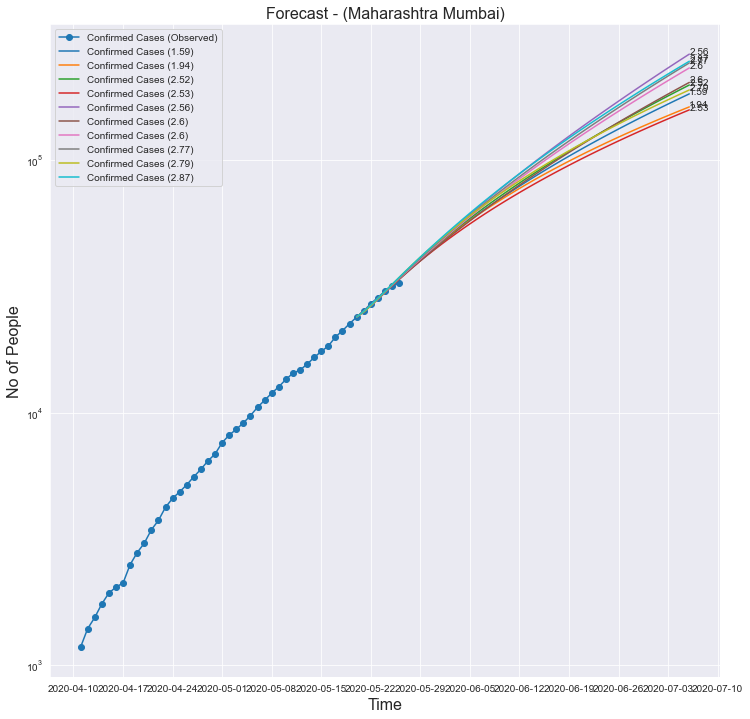

In [56]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']

#sns.set_style("ticks")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

In [22]:
df_true

,date,state,district,total_infected,hospitalised,recovered,deceased
0,2020-04-11,Maharashtra,Mumbai,1182,1036,71,75
1,2020-04-12,Maharashtra,Mumbai,1399,1211,97,91
2,2020-04-13,Maharashtra,Mumbai,1549,1308,141,100
3,2020-04-14,Maharashtra,Mumbai,1753,1478,164,111
4,2020-04-15,Maharashtra,Mumbai,1936,1642,181,113
5,2020-04-16,Maharashtra,Mumbai,2043,1725,202,116
6,2020-04-17,Maharashtra,Mumbai,2120,1760,239,121
7,2020-04-18,Maharashtra,Mumbai,2509,2103,281,125
8,2020-04-19,Maharashtra,Mumbai,2798,2357,310,131
9,2020-04-20,Maharashtra,Mumbai,3050,2518,394,138


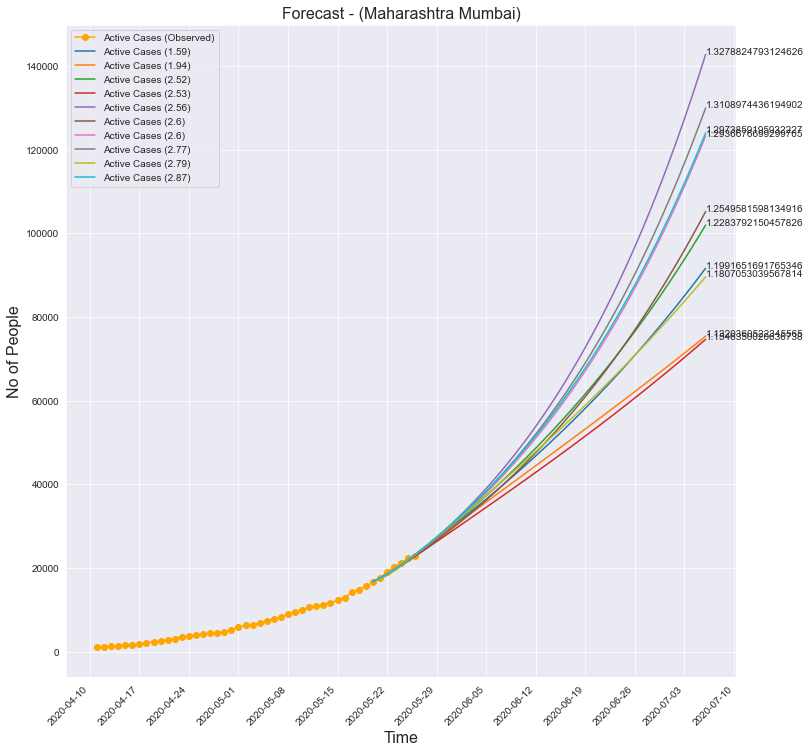

In [57]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [33]:
params_to_plot = \
{
    'low':{'E_hosp_ratio': 0.115406221316017, 'I_hosp_ratio': 0.4763871081949848, 'P_fatal': 0.050419345187462467, 'P_severe': 0.7809853621826006, 'T_inc': 4.484977212179257, 'T_inf': 3.3342249004558697, 'T_recov_severe': 52.054485355979445, 'lockdown_R0': 1.0974118812671074},
    'medium':{'E_hosp_ratio': 0.5105188613649609, 'I_hosp_ratio': 0.3039459885534656, 'P_fatal': 0.05832975188719784, 'P_severe': 0.8668707539589996, 'T_inc': 4.554494614633725, 'T_inf': 3.3958101193846915, 'T_recov_severe': 48.49542471232895, 'lockdown_R0': 1.1227557408135034},
    'high':   {'E_hosp_ratio': 0.2806960144261442, 'I_hosp_ratio': 0.3800638057872212, 'P_fatal': 0.05326820833691313, 'P_severe': 0.8339542948758695, 'T_inc': 4.304052648857938, 'T_inf': 3.4673218430188513, 'T_recov_severe': 47.044942872805294, 'lockdown_R0': 1.3444274930627533}
}
multipliers = [0.9, 1, 1.1, 1.25]
columns_for_csv = ['date', 'total_infected', 'hospitalised', 'recovered', 'deceased']


In [34]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params


predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=set_r0_multiplier(best_params_dict, mul)) \
                                 for mul in multipliers]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [45]:
df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             train_on_val = True, which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss)
    #print(df_loss.sum())

splitting data ..
R0 1.0974118812671074
getting forecasts ..
                   train
hospitalised     1.42223
total_infected  0.906401
deceased        0.730306
recovered       0.920721
R0 1.1227557408135034
getting forecasts ..
                   train
hospitalised    0.911708
total_infected  0.654029
deceased        0.452184
recovered       0.705146
R0 1.3444274930627533
getting forecasts ..
                   train
hospitalised    0.998566
total_infected  0.645198
deceased         0.89068
recovered         1.1296


getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-low-0.9.csv
Mumbai-low-1.csv
Mumbai-low-1.1.csv
Mumbai-low-1.25.csv


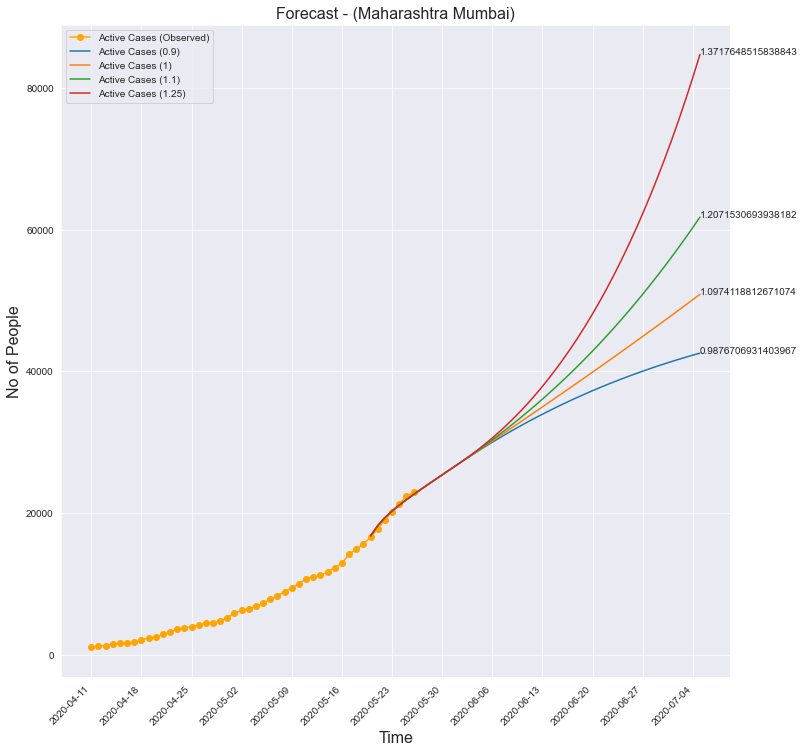

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-medium-0.9.csv
Mumbai-medium-1.csv
Mumbai-medium-1.1.csv
Mumbai-medium-1.25.csv


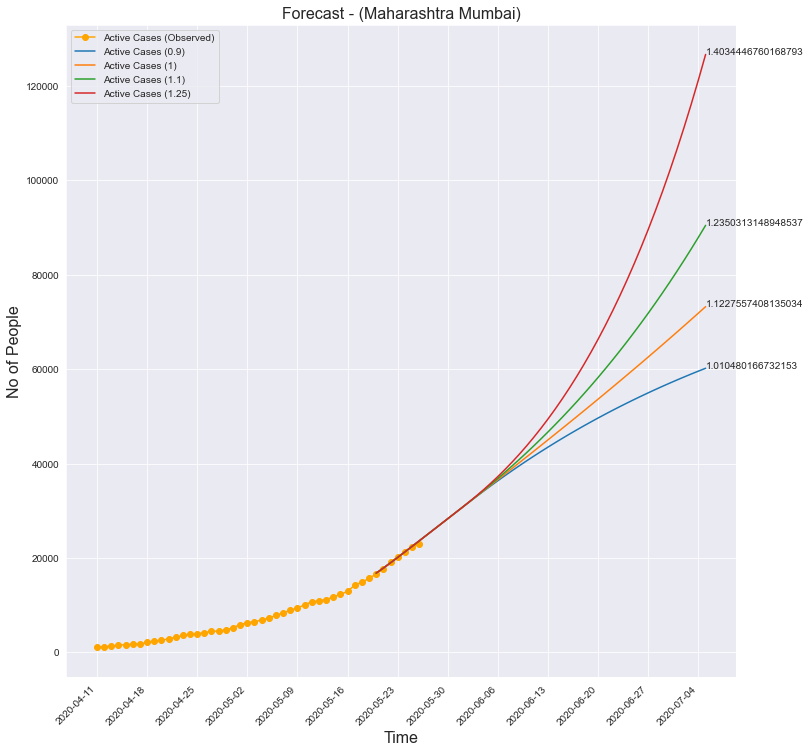

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-high-0.9.csv
Mumbai-high-1.csv
Mumbai-high-1.1.csv
Mumbai-high-1.25.csv


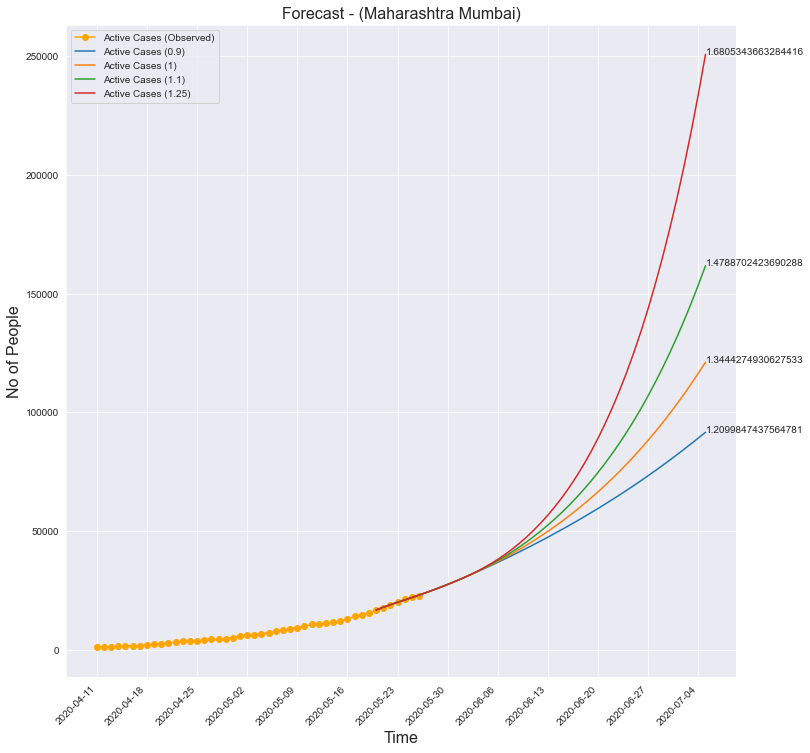

In [36]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
params_array[least_losses_indices[:10]]
for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Mumbai-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        df_prediction[columns_for_csv].to_csv("../../outputs/mumbai-28-05-2020/"+filename)
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xticks(rotation=45,horizontalalignment='right')

    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [70]:

for elt in params_array[least_losses_indices[:10]]:
    print("R0", elt['lockdown_R0'])
    #best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m1",
                                best_params = elt)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             train_on_val = True, which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.iloc[1])


R0 1.1991651691765346
getting forecasts ..
train    0.650291
Name: total_infected, dtype: object
R0 1.1320360522345565
getting forecasts ..
train    0.666329
Name: total_infected, dtype: object
R0 1.2283792150457826
getting forecasts ..
train    0.740678
Name: total_infected, dtype: object
R0 1.1546350020636738
getting forecasts ..
train    1.56162
Name: total_infected, dtype: object
R0 1.3278824793124626
getting forecasts ..
train    1.48868
Name: total_infected, dtype: object
R0 1.2549581598134916
getting forecasts ..
train    1.41827
Name: total_infected, dtype: object
R0 1.2936676699299765
getting forecasts ..
train    0.794034
Name: total_infected, dtype: object
R0 1.3108974436194902
getting forecasts ..
train    1.54961
Name: total_infected, dtype: object
R0 1.1807053039567814
getting forecasts ..
train    2.5025
Name: total_infected, dtype: object
R0 1.2973859195932227
getting forecasts ..
train    2.80784
Name: total_infected, dtype: object


In [28]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1], regionType='district', best_params=params_dict,
                                  initialisation='intermediate', train_period=7, icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [29]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [30]:
df_final

,forecastRunDate,regionType,region,model_name,error_function,error_value,current_total,current_active,current_recovered,current_deceased,...,icu_max,deceased_mean,deceased_min,deceased_max,recovered_mean,recovered_min,recovered_max,total_mean,total_min,total_max
0,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,1182,NaN,71,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,1399,NaN,97,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,1549,NaN,141,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,1753,NaN,164,111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,1936,NaN,181,113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,NaN,NaN,NaN,NaN,...,1854,3898,3744.43,4051.57,46577,42319.7,50834.3,139442,138535,140349
846,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,NaN,NaN,NaN,NaN,...,1933.65,4051,3891.4,4210.6,48668,44219.6,53116.4,145508,144562,146454
847,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,NaN,NaN,NaN,NaN,...,2016.76,4211,4045.09,4376.91,50849,46201.2,55496.8,151837,150850,152824
848,2020-05-28,district,Mumbai,SEIR,MAPE,0.650291,NaN,NaN,NaN,NaN,...,2103.47,4377,4204.55,4549.45,53125,48269.2,57980.8,158440,157410,159470


In [31]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

Loss -  1.98
Params -  {'E_hosp_ratio': 0.19, 'I_hosp_ratio': 0.44, 'P_fatal': 0.06, 'P_severe': 0.84, 'T_inc': 4.94, 'T_inf': 3.73, 'T_recov_severe': 49.41, 'true_R0': 1.49}


Loss -  2.16
Params -  {'E_hosp_ratio': 0.26, 'I_hosp_ratio': 0.41, 'P_fatal': 0.06, 'P_severe': 0.84, 'T_inc': 4.77, 'T_inf': 3.75, 'T_recov_severe': 50.89, 'true_R0': 1.43}


Loss -  2.2
Params -  {'E_hosp_ratio': 0.26, 'I_hosp_ratio': 0.44, 'P_fatal': 0.05, 'P_severe': 0.81, 'T_inc': 4.73, 'T_inf': 3.72, 'T_recov_severe': 50.93, 'true_R0': 1.45}


Loss -  2.28
Params -  {'E_hosp_ratio': 0.23, 'I_hosp_ratio': 0.41, 'P_fatal': 0.06, 'P_severe': 0.85, 'T_inc': 4.95, 'T_inf': 3.74, 'T_recov_severe': 48.57, 'true_R0': 1.48}


Loss -  2.28
Params -  {'E_hosp_ratio': 0.24, 'I_hosp_ratio': 0.43, 'P_fatal': 0.06, 'P_severe': 0.87, 'T_inc': 4.96, 'T_inf': 3.83, 'T_recov_severe': 47.03, 'true_R0': 1.46}


Loss -  2.63
Params -  {'E_hosp_ratio': 0.15, 'I_hosp_ratio': 0.45, 'P_fatal': 0.06, 'P_severe': 0.81, 'T_inc': 4.87